# Quantization of Keyword spotting model

<hr>

# Import and misc

In [1]:
from typing import Tuple, Union, List, Callable, Optional
import dataclasses

from tqdm import tqdm
import pathlib
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [2]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = 'cpu'#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [69]:
@dataclasses.dataclass
class StudentTaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 6
    kernel_size: Tuple[int, int] = (4, 15) #(5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 50
    gru_num_layers: int = 1
    bidirectional: bool = False
    num_classes: int = 2
    loss_alpha: float =0.8
    loss_T: int = 20
    sample_rate: int = 16000
    device: torch.device = torch.device( 'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [2]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2022-04-07 12:49:23--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.157.128, 2404:6800:4008:c13::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.157.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G  49.1MB/s    in 37s     

2022-04-07 12:50:01 (38.3 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [43]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [44]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [45]:
dataset.csv.sample(5)

,path,keyword,label
31691,speech_commands/nine/229978fd_nohash_2.wav,nine,0
28548,speech_commands/off/a8cb6dda_nohash_0.wav,off,0
35963,speech_commands/house/f174517e_nohash_0.wav,house,0
63461,speech_commands/bird/ced4e2a1_nohash_0.wav,bird,0
23145,speech_commands/two/da584bc0_nohash_3.wav,two,0


### Augmentations

In [46]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [47]:
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [48]:
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [49]:
def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [50]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [51]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [52]:
train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [53]:
class LogMelspec:

    def __init__(self, is_train, config):
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)


        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [54]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [55]:
def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
  
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [56]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)

    return -np.trapz(y=FRs, x=FAs)

# Model

In [57]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

In [58]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        logits = model(batch)

        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        opt.step()

        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [59]:
def loss_fn_kd(outputs, labels, teacher_outputs, params):
    alpha = params.loss_alpha
    T = params.loss_T
    KD_loss = nn.KLDivLoss()(F.log_softmax(outputs/T, dim=1),
                             F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T) + \
              F.cross_entropy(outputs, labels) * (1. - alpha)

    return KD_loss


def train_epoch_knowledge_distilation(model, opt, teacher_model , loader, log_melspec, params : StudentTaskConfig):
    model.train()
    device = params.device
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        logits = model(batch)
        probs = F.softmax(logits, dim=-1)

        teacher_logits = teacher_model(batch)

        loss = loss_fn_kd(logits, labels, teacher_logits, params)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        opt.step()

        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [60]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [61]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

# Teacher

In [89]:
config = TaskConfig()
model = CRNN(config)
# model.load_state_dict(torch.load("/content/model_weights.pt",map_location=torch.device('cpu')))
model.to(config.device)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

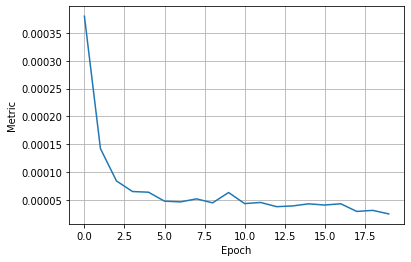

END OF EPOCH 19


In [90]:
opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)


history = defaultdict(list)

for n in range(TaskConfig.num_epochs):

      train_epoch(model, opt, train_loader,
                  melspec_train, config.device)

      au_fa_fr = validation(model, val_loader,
                            melspec_val, config.device)
      history['val_metric'].append(au_fa_fr)

      clear_output()
      plt.plot(history['val_metric'])
      plt.ylabel('Metric')
      plt.xlabel('Epoch')
      plt.grid()
      plt.show()

      print('END OF EPOCH', n)

In [91]:
torch.save(model.state_dict(), "learnt_teacher_model.pt")

# Training

In [31]:
def count_parameters(model: nn.Module):
  print("Model parameters:",sum([p.numel() for p in model.parameters()]))

count_parameters(model)

Model parameters: 70443


## Student model

In [62]:
class StudentAttention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)


class StudentCRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.quant = torch.quantization.QuantStub()

        self.conv = nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            )
        self.relu= nn.ReLU()
        
        self.flatten=nn.Flatten(start_dim=1, end_dim=2)

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)

        self.dequant = torch.quantization.DeQuantStub()
    
    def forward(self, input):
        input=self.quant(input)
        input = input.unsqueeze(dim=1)
        conv_output = self.flatten(self.conv(input)).transpose(-1, -2)

        conv_output = self.dequant(conv_output)
        gru_output, _ = self.gru(conv_output)
        gru_output = self.quant(gru_output)

        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        output = self.dequant(output)
        return output

In [63]:
import os

def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
    os.remove('tmp.pt')

In [70]:
student_config = StudentTaskConfig()
model_quantized = StudentCRNN(student_config)
# model_quantized.load_state_dict(torch.load("/content/teacher_trained.pt"))
print(model_quantized)

StudentCRNN(
  (quant): QuantStub()
  (conv): Conv2d(1, 6, kernel_size=(4, 15), stride=(2, 8))
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=2)
  (gru): GRU(114, 50, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): Tanh()
      (2): Linear(in_features=50, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=50, out_features=2, bias=True)
  (dequant): DeQuantStub()
)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [71]:
print_model_size(model)
print_model_size(model_quantized)

0.29 MB
0.12 MB


In [73]:
import torch
from torch import nn

student_config = StudentTaskConfig()
model_student = StudentCRNN(student_config)
print_model_size(model_student)


config = TaskConfig()
model = CRNN(config)
model.load_state_dict(torch.load("/content/teacher_trained.pt", map_location=torch.device('cpu')))
model.to(config.device)

0.12 MB


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

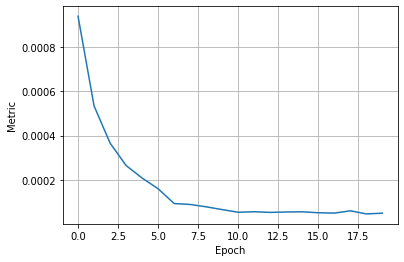

END OF EPOCH 19
0.12 MB


In [74]:
# """Prepare"""

# model_quantized.train()
# model_quantized.qconfig = torch.quantization.get_default_qconfig(backend)

# """Fuse"""
# torch.quantization.fuse_modules(model_quantized, [['conv','relu']], inplace=True) # fuse first Conv-ReLU pair

# torch.quantization.prepare_qat(model_quantized, inplace=True)



"""Training Loop"""

model_student.to(config.device)

opt = torch.optim.Adam(
    model_student.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)


for n in range(TaskConfig.num_epochs):

    train_epoch_knowledge_distilation(
        model_student, opt, model,
        train_loader,melspec_train,student_config
    )

    au_fa_fr = validation(
        model_student, val_loader,
        melspec_val, config.device
    )
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)




model_student.to("cpu")
"""Convert"""
# model_quantized.eval()
# torch.quantization.convert(model_quantized, inplace=True)
print_model_size(model_student)

In [75]:
torch.save(model_student.state_dict(), "student_learnt2.pt")

In [76]:
print_model_size(model_student)

0.12 MB


In [79]:
student_val = validation(model_student, val_loader,melspec_val, config.device)


102it [00:12,  8.38it/s]


In [80]:
teacher_val = validation(model, val_loader,melspec_val, config.device)

102it [00:12,  7.94it/s]


In [ ]:
model_student_learnt = StudentCRNN(student_config)
model_student_learnt.load_state_dict(torch.load("student_learnt2.pt"))
model_student_learnt.eval()

StudentCRNN(
  (quant): QuantStub()
  (conv): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=2)
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
  (dequant): DeQuantStub()
)

In [81]:
from torch.quantization import quantize_dynamic
model_student_learnt_quantized = quantize_dynamic(
    model=model_student, qconfig_spec={ nn.Linear,nn.GRU}, dtype=torch.qint8, inplace=False
)
model_student_learnt_quantized

/usr/local/lib/python3.7/dist-packages/torch/nn/quantized/dynamic/modules/rnn.py:64: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


StudentCRNN(
  (quant): QuantStub()
  (conv): Conv2d(1, 6, kernel_size=(4, 15), stride=(2, 8))
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=2)
  (gru): DynamicQuantizedGRU(114, 50, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): DynamicQuantizedLinear(in_features=50, out_features=50, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
      (1): Tanh()
      (2): DynamicQuantizedLinear(in_features=50, out_features=1, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    )
  )
  (classifier): DynamicQuantizedLinear(in_features=50, out_features=2, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (dequant): DeQuantStub()
)

In [84]:
print_model_size(model)
print_model_size(model_student)
print_model_size(model_student_learnt_quantized)

0.29 MB
0.12 MB
0.04 MB


In [85]:
model_student_learnt_quantized.to('cpu')
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

quantized_val = validation(model_student_learnt_quantized, val_loader,melspec_val, 'cpu')

102it [00:12,  8.20it/s]


In [87]:
print(teacher_val)
print(student_val)
print(quantized_val)

1.7900852479090836e-05
4.990063287333984e-05
4.901445205754327e-05


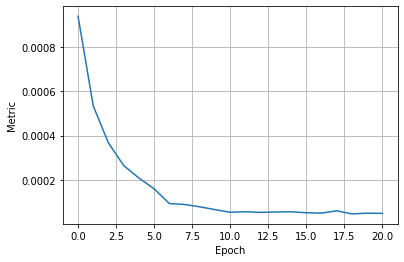

END OF EPOCH 19


In [88]:
au_fa_fr = validation(model_student_learnt_quantized, val_loader,
                      melspec_val, 'cpu')
history['val_metric'].append(au_fa_fr)

clear_output()
plt.plot(history['val_metric'])
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.grid()
plt.show()

print('END OF EPOCH', n)